In [1]:
# Full Kaggle-ready reproducible notebook cell
import os, glob, gc, time, warnings
warnings.filterwarnings("ignore")
import numpy as np, pandas as pd, matplotlib.pyplot as plt, seaborn as sns
from sklearn.model_selection import train_test_split, GroupShuffleSplit, StratifiedKFold, cross_val_score
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.feature_selection import SelectKBest, mutual_info_classif
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import (
    accuracy_score, classification_report, confusion_matrix,
    roc_curve, auc, precision_recall_curve, average_precision_score,
    balanced_accuracy_score
)

# ✅ Fixed styling
sns.set_theme(style="whitegrid", context="notebook")


# ---------- PARAMETERS ----------
DATA_DIR = "/home/rafia-khan/Downloads/kaggle"
SAMPLE_FRAC = 0.05    # set to 1.0 if you want full dataset and have RAM (~16GB on Kaggle)
RANDOM_STATE = 42
TOP_K_FEATURES = 40   # feature selection
RANDOM_FOREST_EST = 100

start_time = time.time()

# ---------- 1) LOAD CSVs and attach source file id ----------
csv_files = glob.glob(os.path.join(DATA_DIR, "*.csv"))
if len(csv_files) == 0:
    raise FileNotFoundError(f"No CSVs found in {DATA_DIR} - check dataset path.")
print("Found CSV files:", len(csv_files))

parts = []
for idx, f in enumerate(csv_files):
    try:
        df_tmp = pd.read_csv(f, low_memory=False)
        if SAMPLE_FRAC < 1.0:
            # sample by fraction, but keep some stability if file small
            n = max(1, int(len(df_tmp) * SAMPLE_FRAC))
            df_tmp = df_tmp.sample(n=n, random_state=RANDOM_STATE)
        df_tmp['__source_file__'] = idx
        parts.append(df_tmp)
        print(f"Loaded {os.path.basename(f)} -> shape {df_tmp.shape}")
    except Exception as e:
        print("Error reading", f, e)
df = pd.concat(parts, ignore_index=True)
print("Concatenated shape:", df.shape)
gc.collect()

# ---------- 2) locate label column ----------
label_col = None
for cand in ['label','Label','attack','Attack','Type','type','category','Category','Class','class']:
    if cand in df.columns:
        label_col = cand
        break
if label_col is None:
    for c in df.columns:
        if 'label' in c.lower() or 'attack' in c.lower() or 'type' in c.lower():
            label_col = c
            break
if label_col is None:
    raise ValueError("Could not detect label column automatically. Inspect df.columns and set label_col manually.")
print("Using label column:", label_col)

# ---------- 3) Basic diagnostics ----------
print("\n=== Diagnostics: basic info ===")
print("Rows:", len(df))
print("Columns:", len(df.columns))
print("Sample columns:", df.columns.tolist()[:30])

# show top label values
print("\nLabel value counts (top 20):")
print(df[label_col].value_counts().head(20))

# ---------- 4) candidate ID/leak columns detection ----------
# flags: columns with high uniqueness (likely ids), columns matching label strings, and high numeric correlation
drop_candidates = set()
# 4a) high cardinality object columns
for c in df.columns:
    if c == label_col or c == '__source_file__': continue
    if df[c].dtype == object:
        if df[c].nunique() > 0.9 * len(df):
            drop_candidates.add(c)

# 4b) columns overlapping label strings (>95% identical)
lbl_strings = df[label_col].astype(str)
for c in df.columns:
    if c == label_col or c == '__source_file__': continue
    try:
        overlap = (df[c].astype(str) == lbl_strings).mean()
        if overlap > 0.95:
            drop_candidates.add(c)
    except Exception:
        pass

# 4c) numeric columns with extremely high correlation to encoded label
le_tmp = LabelEncoder()
y_tmp = le_tmp.fit_transform(lbl_strings)
num_cols = df.select_dtypes(include=[np.number]).columns.tolist()
num_cols = [c for c in num_cols if c not in ('__source_file__',)]
corrs = {}
for c in num_cols:
    try:
        corr = abs(pd.Series(df[c]).corr(pd.Series(y_tmp)))
        corrs[c] = corr
        if corr > 0.9:
            drop_candidates.add(c)
    except Exception:
        pass

print("\nDetected drop candidates (example up to 30):")
print(list(drop_candidates)[:30])
print("\nTop numeric correlations with label (top 10):")
print(pd.Series(corrs).sort_values(ascending=False).head(10))

Found CSV files: 169
Loaded part-00059-363d1ba3-8ab5-4f96-bc25-4d5862db7cb9-c000.csv -> shape (12259, 48)
Loaded part-00048-363d1ba3-8ab5-4f96-bc25-4d5862db7cb9-c000.csv -> shape (10993, 48)
Loaded part-00140-363d1ba3-8ab5-4f96-bc25-4d5862db7cb9-c000.csv -> shape (22460, 48)
Loaded part-00139-363d1ba3-8ab5-4f96-bc25-4d5862db7cb9-c000.csv -> shape (12107, 48)
Loaded part-00099-363d1ba3-8ab5-4f96-bc25-4d5862db7cb9-c000.csv -> shape (12086, 48)
Loaded part-00007-363d1ba3-8ab5-4f96-bc25-4d5862db7cb9-c000.csv -> shape (11395, 48)
Loaded part-00101-363d1ba3-8ab5-4f96-bc25-4d5862db7cb9-c000.csv -> shape (11687, 48)
Loaded part-00064-363d1ba3-8ab5-4f96-bc25-4d5862db7cb9-c000.csv -> shape (13153, 48)
Loaded part-00081-363d1ba3-8ab5-4f96-bc25-4d5862db7cb9-c000.csv -> shape (11536, 48)
Loaded part-00102-363d1ba3-8ab5-4f96-bc25-4d5862db7cb9-c000.csv -> shape (11595, 48)
Loaded part-00057-363d1ba3-8ab5-4f96-bc25-4d5862db7cb9-c000.csv -> shape (21479, 48)
Loaded part-00078-363d1ba3-8ab5-4f96-bc25-4d

In [4]:
# ---------- 5) Drop obvious IDs/leaks and very-high-missing cols ----------
# Also drop columns with >50% missing and any textual columns with huge unique values (IDs)
cols_to_drop = set(drop_candidates)
# drop obvious identifiers by keywords
id_keywords = ['ip','address','time','timestamp','date','flow','src','dst','sport','dport','mac','host','device','id']
for c in df.columns:
    if c == label_col or c == '__source_file__': continue
    low = c.lower()
    if any(k in low for k in id_keywords):
        cols_to_drop.add(c)

# drop columns with >50% missing
thresh = int(0.5 * len(df))
for c in df.columns:
    if c == label_col or c == '__source_file__': continue
    if df[c].isna().sum() > thresh:
        cols_to_drop.add(c)

cols_to_drop = sorted(cols_to_drop)
print("\nDropping columns (count={}): {}".format(len(cols_to_drop), cols_to_drop[:40]))

df_clean = df.drop(columns=cols_to_drop, errors='ignore').copy()

# ---------- 6) convert small-cardinality objects to codes, drop big text ----------
obj_cols = df_clean.select_dtypes(include=['object','category']).columns.tolist()
for c in obj_cols:
    if c == label_col: continue
    nuni = df_clean[c].nunique(dropna=True)
    if nuni <= 50:
        df_clean[c] = df_clean[c].astype('category').cat.codes
    else:
        df_clean = df_clean.drop(columns=[c])
print("\nAfter cleaning, shape:", df_clean.shape)


Dropping columns (count=2): ['IPv', 'flow_duration']

After cleaning, shape: (2334251, 46)


In [5]:
# ---------- 7) keep numeric features only and handle missing ----------
df_num = df_clean.select_dtypes(include=[np.number]).copy()
print("Numeric feature shape:", df_num.shape)
df_num = df_num.dropna(axis=1, thresh=int(0.7*len(df_num)))  # keep cols with >=70% non-missing
print("After dropping very-missing numeric cols:", df_num.shape)

# ---------- 8) prepare X, y and inspect classes ----------
X = df_num.drop(columns=['__source_file__'], errors='ignore').reset_index(drop=True)
y_raw = df_clean[label_col].astype(str).reset_index(drop=True)
groups = df_clean['__source_file__'].reset_index(drop=True)  # used for group split

print("\nFinal X shape:", X.shape)
print("Raw label examples:", sorted(y_raw.unique())[:10])
print("Label distribution (counts):")
print(y_raw.value_counts().head(20))

# ---------- 9) Binary conversion? (paper used Normal vs Attack) ----------
unique_labels = y_raw.unique()
if len(unique_labels) > 10:
    print("\nConverting to binary labels (Normal vs Attack) for ease of evaluation")
    norm_tokens = ['normal','benign','benign/normal','normal/benign']
    y_bin = y_raw.apply(lambda s: 'Normal' if any(t in s.lower() for t in norm_tokens) else 'Attack')
else:
    y_bin = y_raw

le = LabelEncoder()
y = le.fit_transform(y_bin)
print("Encoded classes:", list(le.classes_))
print("Class counts (encoded):")
print(pd.Series(y).value_counts())


Numeric feature shape: (2334251, 45)
After dropping very-missing numeric cols: (2334251, 45)

Final X shape: (2334251, 44)
Raw label examples: ['Backdoor_Malware', 'BenignTraffic', 'BrowserHijacking', 'CommandInjection', 'DDoS-ACK_Fragmentation', 'DDoS-HTTP_Flood', 'DDoS-ICMP_Flood', 'DDoS-ICMP_Fragmentation', 'DDoS-PSHACK_Flood', 'DDoS-RSTFINFlood']
Label distribution (counts):
label
DDoS-ICMP_Flood            360884
DDoS-UDP_Flood             270652
DDoS-TCP_Flood             225420
DDoS-PSHACK_Flood          204696
DDoS-SYN_Flood             203058
DDoS-RSTFINFlood           202215
DDoS-SynonymousIP_Flood    179304
DoS-UDP_Flood              165814
DoS-TCP_Flood              133547
DoS-SYN_Flood              101198
BenignTraffic               54933
Mirai-greeth_flood          49615
Mirai-udpplain              44285
Mirai-greip_flood           37680
DDoS-ICMP_Fragmentation     22571
MITM-ArpSpoofing            15448
DDoS-UDP_Fragmentation      14261
DDoS-ACK_Fragmentation      14094


In [6]:
# ---------- 10) Check exact row overlap between files (sanity) ----------
def row_hash(dfdf):
    return pd.util.hash_pandas_object(dfdf, index=False).values
# small check (may be heavy if X large) - use sample for speed if huge
try:
    Ncheck = min(5000, len(X))
    hvals = row_hash(X.sample(Ncheck, random_state=RANDOM_STATE))
    print("Row-hash sample computed OK (size {})".format(Ncheck))
except Exception as e:
    print("Row-hash sample skipped (too big) -", e)

# ---------- 11) Group-wise train/test split (by source file) to avoid leakage ----------
gss = GroupShuffleSplit(n_splits=1, test_size=0.2, random_state=RANDOM_STATE)
train_idx, test_idx = next(gss.split(X, y, groups))
X_train = X.iloc[train_idx].reset_index(drop=True)
X_test  = X.iloc[test_idx].reset_index(drop=True)
y_train = y[train_idx]
y_test  = y[test_idx]
print("\nGroup-wise split done. Train/Test shapes:", X_train.shape, X_test.shape)
print("Train classes:", pd.Series(y_train).value_counts().to_dict(), "Test classes:", pd.Series(y_test).value_counts().to_dict())

# ---------- 12) Scale numeric features ----------
scaler = StandardScaler()
X_train_s = scaler.fit_transform(X_train)
X_test_s  = scaler.transform(X_test)


Row-hash sample computed OK (size 5000)

Group-wise split done. Train/Test shapes: (1872085, 44) (462166, 44)
Train classes: {0: 1828080, 1: 44005} Test classes: {0: 451238, 1: 10928}



Selected top 40 features:
['Header_Length', 'Protocol Type', 'Duration', 'Rate', 'Srate', 'fin_flag_number', 'syn_flag_number', 'rst_flag_number', 'psh_flag_number', 'ack_flag_number', 'ece_flag_number', 'cwr_flag_number', 'ack_count', 'syn_count', 'fin_count', 'urg_count', 'rst_count', 'HTTP', 'HTTPS', 'DNS', 'SSH', 'TCP', 'UDP', 'DHCP', 'ARP', 'ICMP', 'LLC', 'Tot sum', 'Min', 'Max', 'AVG', 'Std', 'Tot size', 'IAT', 'Number', 'Magnitue', 'Radius', 'Covariance', 'Variance', 'Weight']

Model: DecisionTree | Accuracy: 0.9963 | Balanced Acc: 0.9704 | train_time: 7.49s


,precision,recall,f1-score,support
0,0.999,0.998,0.998,451238.000
1,0.906,0.943,0.924,10928.000
accuracy,0.996,0.996,0.996,0.996
macro avg,0.952,0.970,0.961,462166.000
weighted avg,0.996,0.996,0.996,462166.000


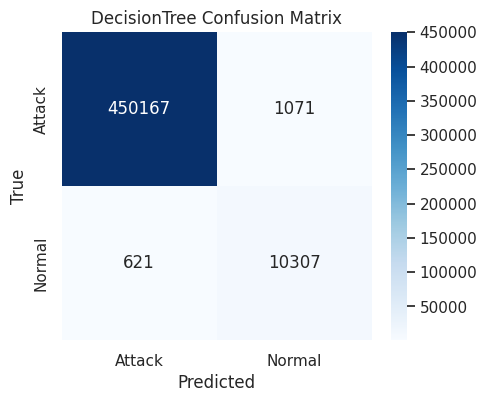

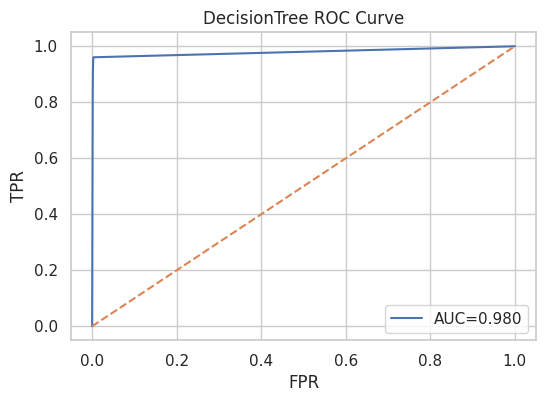

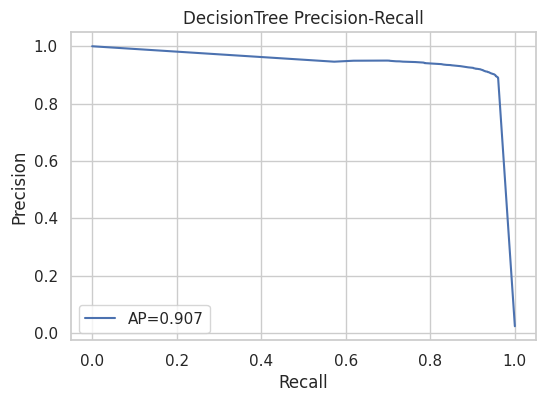


Model: RandomForest | Accuracy: 0.9969 | Balanced Acc: 0.9686 | train_time: 42.28s


,precision,recall,f1-score,support
0,0.999,0.998,0.998,451238.000
1,0.929,0.939,0.934,10928.000
accuracy,0.997,0.997,0.997,0.997
macro avg,0.964,0.969,0.966,462166.000
weighted avg,0.997,0.997,0.997,462166.000


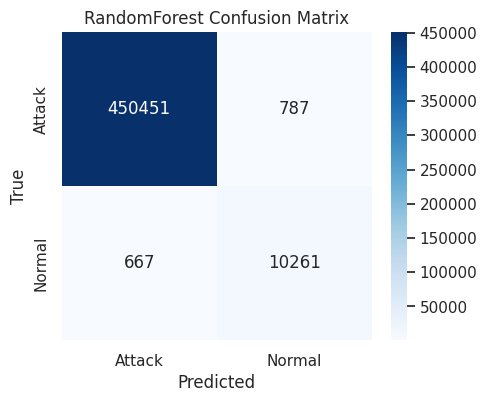

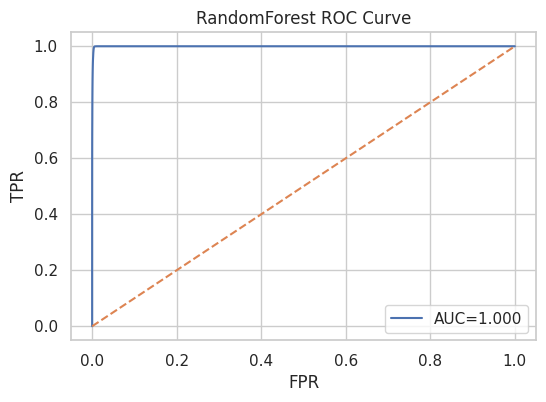

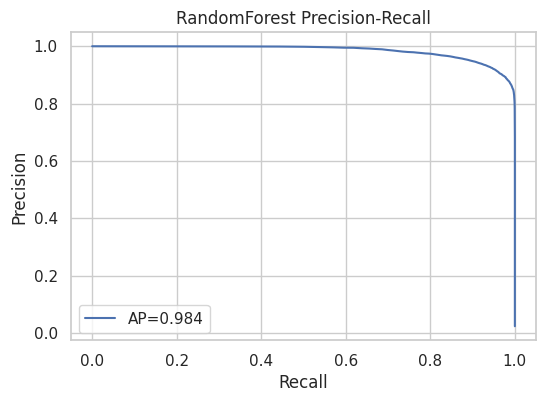


Model: LinearSVC | Accuracy: 0.9762 | Balanced Acc: 0.9856 | train_time: 39.24s


,precision,recall,f1-score,support
0,1.000,0.976,0.988,451238.000
1,0.498,0.996,0.664,10928.000
accuracy,0.976,0.976,0.976,0.976
macro avg,0.749,0.986,0.826,462166.000
weighted avg,0.988,0.976,0.980,462166.000


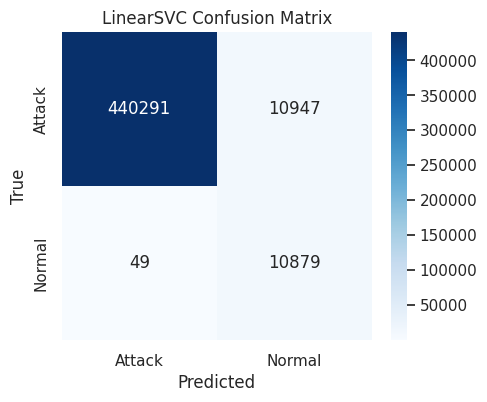

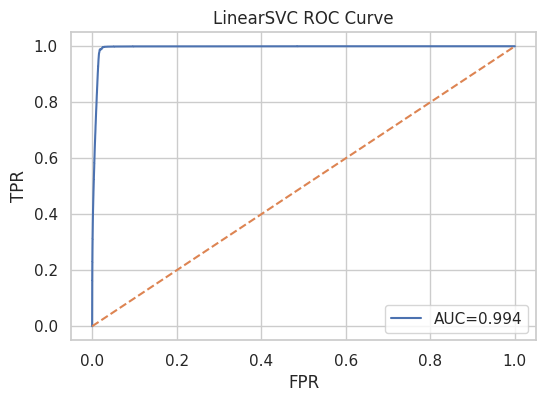

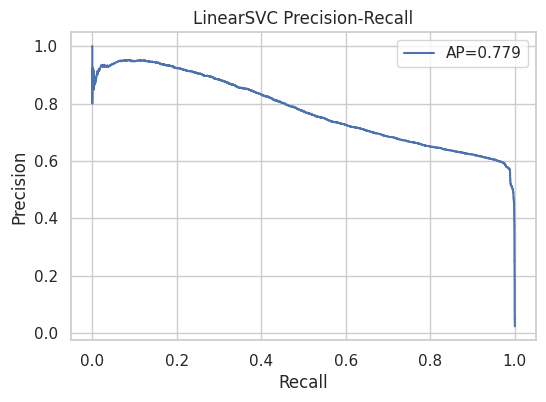


Model: KNN | Accuracy: 0.9911 | Balanced Acc: 0.9239 | train_time: 0.32s


,precision,recall,f1-score,support
0,0.996,0.994,0.995,451238.000
1,0.789,0.853,0.820,10928.000
accuracy,0.991,0.991,0.991,0.991
macro avg,0.893,0.924,0.908,462166.000
weighted avg,0.992,0.991,0.991,462166.000


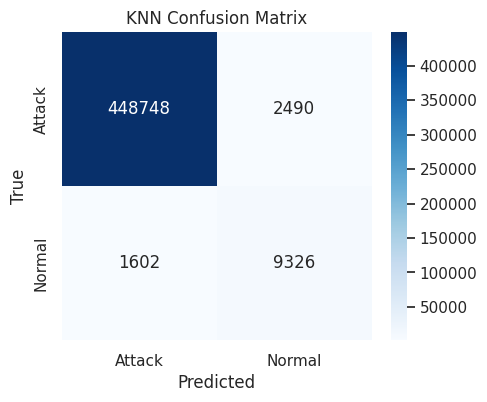

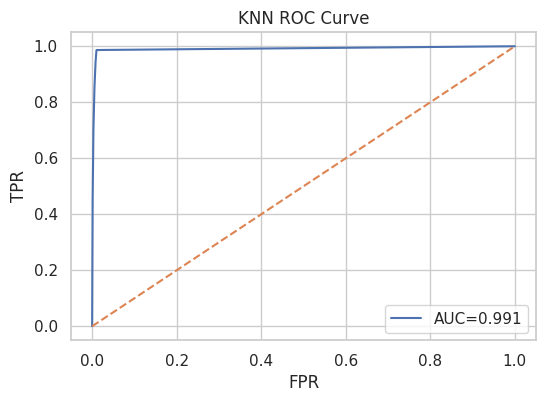

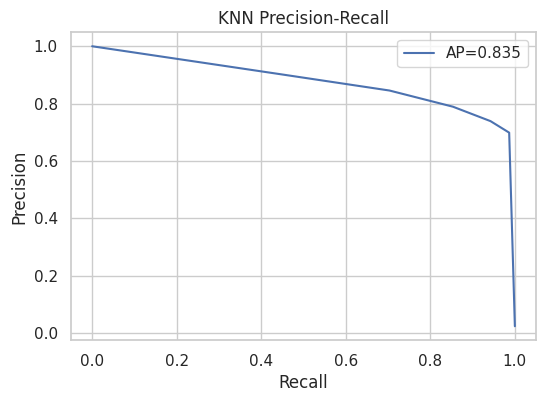

In [7]:


# ---------- 13) Feature selection ----------
k = min(TOP_K_FEATURES, X_train_s.shape[1])
selector = SelectKBest(mutual_info_classif, k=k)
selector.fit(X_train_s, y_train)
X_train_sel = selector.transform(X_train_s)
X_test_sel  = selector.transform(X_test_s)
selected_idx = selector.get_support(indices=True)
selected_features = X.columns[selected_idx].tolist()
print("\nSelected top {} features:".format(len(selected_features)))
print(selected_features)

# ---------- 14) Models to train ----------
models = {
    "DecisionTree": DecisionTreeClassifier(random_state=RANDOM_STATE, max_depth=20),
    "RandomForest": RandomForestClassifier(n_estimators=RANDOM_FOREST_EST, random_state=RANDOM_STATE, n_jobs=-1, class_weight='balanced'),
    "LinearSVC": LinearSVC(max_iter=5000, class_weight='balanced', random_state=RANDOM_STATE),
    "KNN": KNeighborsClassifier(n_neighbors=5, n_jobs=-1)
}

results = {}
# ---------- 15) train / evaluate loop ----------
for name, clf in models.items():
    t0 = time.time()
    clf.fit(X_train_sel, y_train)
    t1 = time.time()
    y_pred = clf.predict(X_test_sel)
    acc = accuracy_score(y_test, y_pred)
    bal_acc = balanced_accuracy_score(y_test, y_pred)
    crep = classification_report(y_test, y_pred, output_dict=True, zero_division=0)
    cm = confusion_matrix(y_test, y_pred)
    results[name] = {"model": clf, "acc": acc, "bal_acc": bal_acc, "report": crep, "cm": cm, "time": t1 - t0}
    print("\nModel:", name, "| Accuracy: {:.4f} | Balanced Acc: {:.4f} | train_time: {:.2f}s".format(acc, bal_acc, t1 - t0))
    display(pd.DataFrame(crep).transpose().round(3))
    # plot confusion matrix
    plt.figure(figsize=(5,4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=le.classes_, yticklabels=le.classes_)
    plt.title(f"{name} Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.show()
    # ROC / PR (binary only)
    try:
        if len(le.classes_) == 2:
            if hasattr(clf, "predict_proba"):
                y_score = clf.predict_proba(X_test_sel)[:,1]
            else:
                try:
                    y_score = clf.decision_function(X_test_sel)
                except Exception:
                    # fallback
                    y_score = clf.predict(X_test_sel)
            fpr, tpr, _ = roc_curve(y_test, y_score)
            roc_auc = auc(fpr, tpr)
            plt.figure(figsize=(6,4)); plt.plot(fpr, tpr, label=f"AUC={roc_auc:.3f}"); plt.plot([0,1],[0,1],'--')
            plt.title(f"{name} ROC Curve"); plt.xlabel("FPR"); plt.ylabel("TPR"); plt.legend(); plt.show()
            precision, recall, _ = precision_recall_curve(y_test, y_score)
            ap = average_precision_score(y_test, y_score)
            plt.figure(figsize=(6,4)); plt.plot(recall, precision, label=f"AP={ap:.3f}")
            plt.title(f"{name} Precision-Recall"); plt.xlabel("Recall"); plt.ylabel("Precision"); plt.legend(); plt.show()
    except Exception as e:
        print("ROC/PR skipped for", name, ":", e)



=== Cross-Validation (StratifiedKFold, 5 splits) on RandomForest ===
CV accuracies: [0.9968 0.9966 0.9968 0.9968 0.9969] mean: 0.9967886915394104 std: 0.00011239666997626723

=== Model comparison ===


,Model,Accuracy,BalancedAcc,TrainTime_s
0,RandomForest,0.996854,0.968610,42.276203
1,DecisionTree,0.996339,0.970400,7.486206
2,KNN,0.991146,0.923943,0.315420
3,LinearSVC,0.976208,0.985628,39.238878


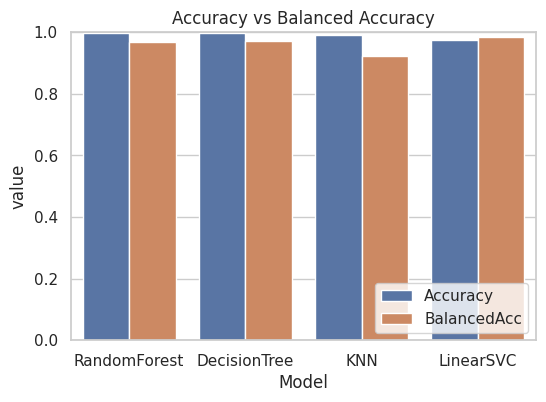


Top 20 RF feature importances:


,feature,importance
0,rst_count,0.184872
1,urg_count,0.130129
2,AVG,0.089917
3,Variance,0.085737
4,Tot size,0.070929
5,Magnitue,0.063974
6,Radius,0.049343
7,Header_Length,0.047112
8,IAT,0.041003
9,Covariance,0.033510


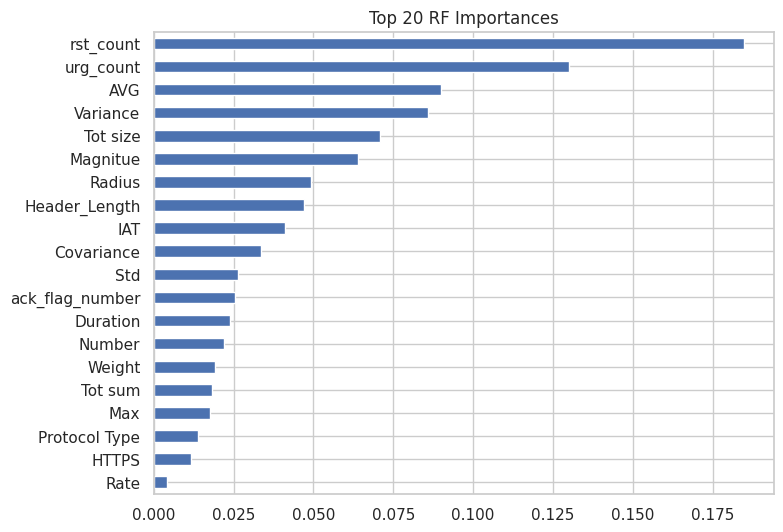


Total elapsed time: 2369.5s


In [8]:


# ---------- 16) Cross-validation (Stratified K-Fold) on selected features (optional but useful) ----------
print("\n=== Cross-Validation (StratifiedKFold, 5 splits) on RandomForest ===")
rf = RandomForestClassifier(n_estimators=RANDOM_FOREST_EST, random_state=RANDOM_STATE, class_weight='balanced', n_jobs=-1)
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)
cv_scores = cross_val_score(rf, np.vstack((X_train_sel, X_test_sel)), np.hstack((y_train, y_test)), cv=skf, scoring='accuracy', n_jobs=-1)
print("CV accuracies:", np.round(cv_scores, 4), "mean:", cv_scores.mean(), "std:", cv_scores.std())

# ---------- 17) Summary table ----------
summary = pd.DataFrame([{"Model": k, "Accuracy": results[k]["acc"], "BalancedAcc": results[k]["bal_acc"], "TrainTime_s": results[k]["time"]} for k in results]).sort_values("Accuracy", ascending=False).reset_index(drop=True)
print("\n=== Model comparison ===")
display(summary)

# bar plot
plt.figure(figsize=(6,4))
sns.barplot(data=summary.melt(id_vars='Model', value_vars=['Accuracy','BalancedAcc']), x='Model', y='value', hue='variable')
plt.ylim(0,1); plt.title("Accuracy vs Balanced Accuracy"); plt.legend(loc='lower right'); plt.show()

# ---------- 18) Feature importances from RandomForest ----------
if 'RandomForest' in results:
    try:
        rf_clf = results['RandomForest']['model']
        importances = rf_clf.feature_importances_
        fi = pd.Series(importances, index=selected_features).sort_values(ascending=False)
        print("\nTop 20 RF feature importances:")
        display(fi.head(20).reset_index().rename(columns={'index':'feature',0:'importance'}))
        plt.figure(figsize=(8,6)); fi.head(20).sort_values().plot(kind='barh'); plt.title("Top 20 RF Importances"); plt.show()
    except Exception as e:
        print("RF feature importances error:", e)

elapsed = time.time() - start_time
print(f"\nTotal elapsed time: {elapsed:.1f}s")
